In [66]:
from tqdm.notebook import tqdm 
import numpy as np
import pandas as pd
import pickle
import torch
import torch.nn as nn
from os import listdir
from nltk.tokenize import word_tokenize
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec


In [67]:
unprocessed_file_name = 'unprocessed_file.pkl'
cleaned_file_name ='cleaned_file.pkl'
cnn = "/Users/rohankilledar/Documents/MSc Artificial Intelligence/repos/summarisation/cnn/stories"
path_of_downloaded_files = "/Users/rohankilledar/Documents/MSc Artificial Intelligence/repos/Natural Language Processing/glove.6B.300d.txt"
filename = "glove.6B.300d.txt"
embedding_dim = 300

In [34]:

def read_file(filename):
    file = open(filename, encoding= 'UTF-8')
    text = file.read()
    file.close()
    return text

text = read_file('/Users/rohankilledar/Documents/MSc Artificial Intelligence/repos/summarisation/cnn/stories/0a0a4c90d59df9e36ffec4ba306b4f20f3ba4acb.story')
#text.split("\n")


In [35]:
def read_file(filename):
    file = open(filename, encoding= 'UTF-8')
    text = file.read()
    file.close()
    return text

def split_text(article):
    indx = article.index('@highlight')
    story = article[:indx]
    highlight = article[indx:].split('@highlight')

    highlight = ". ".join([h.strip() for h in highlight if len(h)>0])
    return story,highlight

In [36]:


def read_all(folder):
    dataset = list()

    for file in tqdm(listdir(folder)):
        filename = folder + '/' + file
        article = read_file(filename)
        story,highlight = split_text(article)

        dataset.append({'story':story, 'highlight':highlight})
    
    return dataset

dataset = read_all(cnn)

  0%|          | 0/92579 [00:00<?, ?it/s]

In [37]:
#saving dataset for cleaning
import pickle
output_file = open(unprocessed_file_name,'wb')
pickle.dump(dataset, output_file)
output_file.close()

In [38]:
df = pd.DataFrame(dataset)

In [39]:
df['word_count_text'] = df['story'].apply(lambda x: len(str(x).split()))
df['highlight_count'] = df['highlight'].apply(lambda x: len(str(x).split()))

In [40]:
from math import floor
print("The mean word count length of text article is " + str(floor(df['word_count_text'].mean())))
print("The mean word count length of summary/highlight is " + str(floor(df['highlight_count'].mean())))

The mean word count length of text article is 654
The mean word count length of summary/highlight is 41


In [41]:
max_article_len = floor(df['word_count_text'].max())
max_summary_len = floor(df['highlight_count'].max())
print("The max word count length of text article is " + str(max_article_len))
print("The max word count length of summary/highlight is " + str(max_summary_len))

The max word count length of text article is 1879
The max word count length of summary/highlight is 106


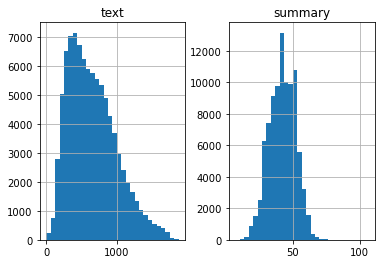

In [42]:

stories = df['story'].tolist()
summaries = df['highlight'].tolist()

import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []
# populate the lists with sentence lengths
for i in stories:
      text_word_count.append(len(i.split()))
for i in summaries:
      summary_word_count.append(len(i.split()))
length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [50]:
df.drop('word_count_text', axis=1, inplace=True)
df.drop('highlight_count', axis=1, inplace=True)

In [52]:
df.isnull().sum()

story        0
highlight    0
dtype: int64

Data Cleaning

In [43]:
import re

def decontracted(phrase): 
    phrase = re.sub(r"won't", "will not", phrase) 
    phrase = re.sub(r"can\'t", "can not", phrase)  
    phrase = re.sub(r"n\'t", " not", phrase)  
    phrase = re.sub(r"\'re", " are", phrase)  
    phrase = re.sub(r"\'s", " is", phrase)  
    phrase = re.sub(r"\'d", " would", phrase)  
    phrase = re.sub(r"\'ll", " will", phrase)  
    phrase = re.sub(r"\'t", " not", phrase)  
    phrase = re.sub(r"\'ve", " have", phrase)  
    phrase = re.sub(r"\'m", " am", phrase)  
    return phrase

In [44]:
def clean_text(data):
    article_text = []
    
    for i in tqdm(data):
        dash_indx = i.find('(CNN) --')
        if dash_indx>=0: #and dash_indx<=20:
            i = i[dash_indx+len('(CNN) --'):]
        tt = re.sub(r'\n',' ', i)
        tt=re.sub(r"([?!¿])", r" \1 ", tt)
        tt=decontracted(tt)
        tt = re.sub('[^A-Za-z0-9.,]+', ' ', tt)
        tt = tt.lower()
        article_text.append(tt)
    return article_text


clean_article = clean_text(stories)
clean_summary = clean_text(summaries)

  0%|          | 0/92579 [00:00<?, ?it/s]

  0%|          | 0/92579 [00:00<?, ?it/s]

In [45]:
df['story'] = clean_article
df['highlight'] = clean_summary

In [53]:
df.isnull().sum()

story        0
highlight    0
dtype: int64

In [47]:
output_file = open(cleaned_file_name,'wb')
pickle.dump(df, output_file)
output_file.close()

In [55]:
train_size = int(0.8 * len(df))
test_size = len(df) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(df, [train_size, test_size])

In [68]:
glove_file = datapath(path_of_downloaded_files)
word2vec_glove_file = get_tmpfile(filename)
glove2word2vec(glove_file, word2vec_glove_file)
word_vectors = KeyedVectors.load_word2vec_format(word2vec_glove_file)
print('loaded %s word vectors from %s.' % (len(word_vectors.key_to_index),filename ))

<ipython-input-68-0c6d93aa8805>:3: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_file, word2vec_glove_file)


loaded 400000 word vectors from glove.6B.300d.txt.


In [64]:
train_word_corpus = []
for article in tqdm(train_dataset.dataset['story']):
    train_word_corpus.extend(word_tokenize(article))

  0%|          | 0/92579 [00:00<?, ?it/s]

In [69]:
print(len(train_word_corpus))
unique_word_corpus = set(train_word_corpus)
unique_word_corpus_len = len(unique_word_corpus)
print(unique_word_corpus_len)
inter_word = set(word_vectors.key_to_index).intersection(unique_word_corpus)
print(len(inter_word))
print("The number of words that are present in both glove vectors and our corpus are {} which \
is nearly {}% ".format(len(inter_word), np.round((float(len(inter_word))/len(unique_word_corpus))
*100)))
out_of_embd_word = unique_word_corpus.difference(set(word_vectors.key_to_index))

67923886
253371
160545
The number of words that are present in both glove vectors and our corpus are 160545 which is nearly 63.0% 


63% seems reseaonable as most of the words out of the word_vocab are either number, proper noun or spelling mistakes.

In [70]:
words = [] 
word2indx = {}
indx2word = {}

with open(path_of_downloaded_files) as f:
    for indx,l in enumerate(f):
        line = l.split()
        word = line[0]
        words.append(word)
        word2indx[word] = indx
        indx2word[indx]=word

glove = {w: word_vectors[word2indx[w]] for w in words}

In [71]:
matrix_len = len(unique_word_corpus)

In [72]:
def generate_weights(unique_word_corpus,glove):
    matrix_len = len(unique_word_corpus)
    unique_word2indx = {}


    weight_matrix  = np.zeros((matrix_len, embedding_dim))
    words_found = 0

    for indx, word in enumerate(unique_word_corpus):
        try:
            unique_word2indx[word] = indx
            weight_matrix[indx] = glove[word]
            words_found +=1
        except KeyError:
            weight_matrix[indx] = np.random.normal(scale=0.6 , size= (embedding_dim,))
            unique_word2indx[word] = indx
    
    return torch.from_numpy(weight_matrix), unique_word2indx

In [73]:
weight_matrix, unique_word2indx = generate_weights(unique_word_corpus,glove)

In [75]:
# save model and other necessary modules
all_info_want_to_save = {
    'words': words,
    'word2indx': word2indx,
    'weight_matrix' : weight_matrix,
    'unique_word2indx' : unique_word2indx,
    'indx2word' : indx2word,
    'glove' : glove
}

with open("vocab.pkl","wb") as save_path:
    pickle.dump(all_info_want_to_save, save_path)


In [79]:
def create_emb_layer(weight_matrix, non_trainable = False):
    num_embeddings, embedding_dim = weight_matrix.shape
    emb_layer = nn.Embedding(num_embeddings,embedding_dim)
    emb_layer.load_state_dict({'weight': weight_matrix})
    if non_trainable:
        emb_layer.weight.requires_grad = False
    return emb_layer,num_embeddings,embedding_dim


In [90]:
def word2tensor(word):
    indx = unique_word2indx[word]
    return weight_matrix[indx]

def sequence2tensor(seq):
    sequenceList = []
    for word in word_tokenize(seq):
        sequenceList.append(word2tensor(word))
    return sequenceList


In [83]:
seqtensor = sequence2tensor(train_dataset.dataset['story'][0])

In [87]:
len(seqtensor)

555

In [89]:
len(word_tokenize(train_dataset.dataset['story'][0]))

555

In [80]:
class Encoder(nn.Module):
  def __init__(self, input_size, hidden_size,weight_matrix, bidirectional = True):
    super(Encoder, self).__init__()
    self.hidden_size = hidden_size
    self.input_size = input_size
    self.bidirectional = bidirectional
    self.embedding, self.num_embeddings, embedding_dim = create_emb_layer(weight_matrix,True)
    
    self.lstm = nn.LSTM(input_size, hidden_size, bidirectional = bidirectional)
  
  def forward(self, inputs, hidden):
    inputs = self.embedding(inputs)
    output, hidden = self.lstm(inputs.view(1, 1, self.input_size), hidden)
    return output, hidden
    
  def init_hidden(self):
    return (torch.zeros(1 + int(self.bidirectional), 1, self.hidden_size),
      torch.zeros(1 + int(self.bidirectional), 1, self.hidden_size))

In [94]:
type(seqtensor[0])

hidden = encoder.init_hidden()

In [77]:
input_size= len(word_tokenize(train_dataset.dataset['story'][0]))

In [95]:
encoder = Encoder(input_size,128,weight_matrix,True)

out,hidden =encoder.forward(seqtensor[0],hidden)

RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.DoubleTensor instead (while checking arguments for embedding)